In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Set global variables to run notebook
data_root = 'C:/_data/' # set to whever the data is being stored

train_with_true_labels = False
if train_with_true_labels:
    feature_file = os.path.join(data_root, 'commercials\\data\\true_labels_images_features.txt')
else:
    feature_file = os.path.join(data_root, 'commercials\\data\\rekall_train_images_features.txt')

test_with_true_labels = True
test_file = os.path.join(data_root, 'commercials\\data\\true_labels_images_features.txt')
percent_for_test = 0.10 # used for splitting data when not testing with true labels

num_features_to_use = 26

In [2]:
def load_data(filename):
    
    videos = []
    images = []
    y = []
    x = []
    
    with open(filename, 'r') as f:
        for line in f.readlines():
            video, image, label, data = line.split(',', 3)
            videos.append(int(video))
            images.append(int(image))
            y.append(int(label))
            x.append(eval(data))
    
    y = np.array(y).reshape(len(y), 1)
    x = np.array(x)
    
    return videos, images, y, x

In [3]:
# load training data
videos, images, y, x = load_data(feature_file)
print('Loaded %d data points' % len(images))

x = x[:, :num_features_to_use]

# shuffle data
data = list(zip(y, x))
random.shuffle(data)
y, x = zip(*data)
y_train = np.array(y).reshape(len(y), 1)
x_train = np.array(x)
print('y_train is shape ', y_train.shape)
print('x_train is shape ', x_train.shape)

Loaded 64130 data points
y_train is shape  (64130, 1)
x_train is shape  (64130, 26)


In [4]:
# set up the test data
if test_with_true_labels:
    videos, images, y, x = load_data(test_file) # load true labes for testing
    x = x[:, :num_features_to_use]
    x_test = x #np.array(list(zip(avgs, stddevs)))
    y_test = y #np.array(labels).reshape(len(labels), 1)
else: # remove test from dataset
    split = int(len(y) * percent_for_test)
    x_train = np.array(x[split:])
    y_train = np.array(y[split:]).reshape(len(y)-split, 1)
    x_test = np.array(x[:split])
    y_test = np.array(y[:split]).reshape(split,1)

print('Loaded %d test points' % len(y))
print('y_test is shape ', y_test.shape)
print('x_test is shape ', x_test.shape)

Loaded 81105 test points
y_test is shape  (81105, 1)
x_test is shape  (81105, 26)


In [26]:
def compute_parameters(x_train, y_train):
    
    n = len(y_train)
    phi = np.sum(y_train) / n
    mu0 = np.sum(x_train * (1 - y_train), axis=0) / np.sum(1 - y_train)
    mu1 = np.sum(x_train * y_train, axis=0) / np.sum(y_train)

    d = mu0.shape[0]
    sigma0 = np.zeros((d, d))
    sigma1 = np.zeros((d, d))
    
    for i in range(n):
        if y_train[i]:
            vec = x_train[i] - mu1
            sigma1 += np.outer(vec, vec)
        else:
            vec = x_train[i] - mu0
            sigma0 += np.outer(vec, vec)
            
    sigma0 = sigma0 / np.sum(1 - y_train)
    sigma1 = sigma1 / np.sum(y_train)
    sigma = (sigma0 * np.sum(1 - y_train) + sigma1 * np.sum(y_train)) / n
    
    return phi, mu0, mu1, sigma0, sigma1, sigma

In [27]:
def gaussian_prob(x, mu, inv_sigma, sqrt_det_sigma):
    return np.exp(-np.dot(x - mu, np.dot(inv_sigma, x - mu))/2) / ((2*np.pi)**(mu.shape[0]/2) * sqrt_det_sigma)

In [28]:
def make_predictions(x_test, y_test, phi, mu0, mu1, sigma0, sigma1):
    
    inv_sigma0 = np.linalg.inv(sigma0)
    sqrt_det_sigma0 = np.sqrt(np.linalg.det(sigma0))
    inv_sigma1 = np.linalg.inv(sigma1)
    sqrt_det_sigma1 = np.sqrt(np.linalg.det(sigma1))
    
    predictions = []
    tp = tn = fp = fn = 0
    for i in range(len(y_test)):
        x = x_test[i]
        neg = gaussian_prob(x, mu0, inv_sigma0, sqrt_det_sigma0) * (1 - phi)
        pos = gaussian_prob(x, mu1, inv_sigma1, sqrt_det_sigma1) * phi
        prediction = pos > neg
        predictions.append(prediction)
        if prediction == True and y_test[i] == 1:
            tp += 1
        if prediction == True and y_test[i] == 0:
            fp += 1
        if prediction == False and y_test[i] == 1:
            fn += 1
        if prediction == False and y_test[i] == 0:
            tn += 1
    
    predictions = np.array(predictions).reshape(len(predictions), 1)
    accuracy = np.sum((predictions == y_test) * 1) / len(predictions)
    F1 = 2 * tp / (2 * tp + fn + fp)
    
    print(tp, fp, fn, tn)
    n = tp + fp + fn + tn
    print(tp/n, fp/n, fn/n, tn/n)
    
    return accuracy, F1

In [29]:
phi, mu0, mu1, sigma0, sigma1, sigma = compute_parameters(x_train[:10000], y_train[:10000])

print('Results with single Sigma')
accuracy, F1 = make_predictions(x_test, y_test, phi, mu0, mu1, sigma, sigma)
print('Accuracy = %f and F1 = %f' % (accuracy, F1))

print('\nResults with two Sigmas')
accuracy, F1 = make_predictions(x_test, y_test, phi, mu0, mu1, sigma0, sigma1)
print('Accuracy = %f and F1 = %f' % (accuracy, F1))

Results with single Sigma
9074 2240 14145 55646
0.1118796621663276 0.027618519203501633 0.174403550952469 0.6860982676777018
Accuracy = 0.797978 and F1 = 0.525526

Results with two Sigmas
10917 3890 12302 53996
0.1346032920288515 0.04796251772393811 0.15167992108994513 0.6657542691572653
Accuracy = 0.800358 and F1 = 0.574186


In [389]:
# compute accuracy for increasing sizes of training data
step_size = len(y_train) // 10
for i in range(step_size, len(y_train), step_size):
    phi, mu0, mu1, sigma0, sigma1 = compute_parameters(x_train[0:i], y_train[0:i])
    accuracy, F1 = make_predictions(x_test, y_test, phi, mu0, mu1, sigma0, sigma1)
    sig0_det = np.linalg.det(sigma0)
    sig1_det = np.linalg.det(sigma1)
    print('%d training examples = %f accuracy and %f F1. S0 = %f. S1 = %f' % (i, accuracy, F1, sig0_det, sig1_det))

C:\Users\mcram\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


6413 training examples = 0.713717 accuracy and 0.000000 F1. S0 = -640.789778. S1 = 152218.950491


C:\Users\mcram\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


12826 training examples = 0.713717 accuracy and 0.000000 F1. S0 = 678.640673. S1 = -152291.134811
19239 training examples = 0.713717 accuracy and 0.000000 F1. S0 = -920.586387. S1 = 15230.028596
25652 training examples = 0.713717 accuracy and 0.000000 F1. S0 = -334.303454. S1 = 145435.560561
32065 training examples = 0.713717 accuracy and 0.000000 F1. S0 = -841.634449. S1 = -361454.828255
38478 training examples = 0.713717 accuracy and 0.000000 F1. S0 = -1022.207630. S1 = 45989.924166
44891 training examples = 0.713717 accuracy and 0.000000 F1. S0 = -277.015944. S1 = 95424.666802
51304 training examples = 0.814611 accuracy and 0.581543 F1. S0 = 94.317003. S1 = 195350.992089
57717 training examples = 0.713717 accuracy and 0.000000 F1. S0 = 83.763054. S1 = -52743.289470


**Graph Results**
This only works when using 2 features.

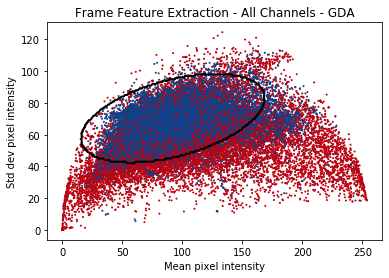

In [11]:
means = x_train[:,[0]]
stddevs = x_train[:,[1]]

color = ['#0b438c' if x==0 else '#bd0413' for x in y_train]
plt.scatter(means, stddevs, c=color, s=1)
plt.title("Frame Feature Extraction - All Channels - GDA")
plt.xlabel("Mean pixel intensity")
plt.ylabel("Std dev pixel intensity")

x_bottom = []
y_bottom = []
x_top = []
y_top = []
x_left = []
y_left = []
x_right = []
y_right = []
inv_sigma0 = np.linalg.inv(sigma0)
sqrt_det_sigma0 = np.sqrt(np.linalg.det(sigma0))
inv_sigma1 = np.linalg.inv(sigma1)
sqrt_det_sigma1 = np.sqrt(np.linalg.det(sigma1))
for i in range(0, 250):
    for j in range(0, 120):
        pos = gaussian_prob([i,  j], mu1, inv_sigma1, sqrt_det_sigma1) * phi
        neg = gaussian_prob([i,  j], mu0, inv_sigma0, sqrt_det_sigma0) * (1 - phi)
        if abs(1 - pos / neg) < .2:
            x_bottom.append(i)
            y_bottom.append(j)
            break
    for j in range(120, 0, -1):
        pos = gaussian_prob([i,  j], mu1, inv_sigma1, sqrt_det_sigma1) * phi
        neg = gaussian_prob([i,  j], mu0, inv_sigma0, sqrt_det_sigma0) * (1 - phi)
        if abs(1 - pos / neg) < .2:
            x_top.append(i)
            y_top.append(j)
            break
for j in range(50, 70):
    for i in range(10, 50):
        pos = gaussian_prob([i,  j], mu1, inv_sigma1, sqrt_det_sigma1) * phi
        neg = gaussian_prob([i,  j], mu0, inv_sigma0, sqrt_det_sigma0) * (1 - phi)
        if abs(1 - pos / neg) < .2:
            x_left.append(i)
            y_left.append(j)
            break
for j in range(70, 90):
    for i in range(200, 150, -1):
        pos = gaussian_prob([i,  j], mu1, inv_sigma1, sqrt_det_sigma1) * phi
        neg = gaussian_prob([i,  j], mu0, inv_sigma0, sqrt_det_sigma0) * (1 - phi)
        if abs(1 - pos / neg) < .2:
            x_right.append(i)
            y_right.append(j)
            break
        
plt.plot(x_bottom, y_bottom, 'k', linewidth=2)
plt.plot(x_top, y_top, 'k', linewidth=2)
plt.plot(x_left, y_left, 'k', linewidth=2)
plt.plot(x_right, y_right, 'k', linewidth=2)

plt.show()

In [9]:
phi, mu0, mu1, sigma0, sigma1 = compute_parameters(x_test, y_test)
phi, mu0, mu1, sigma0, sigma1

(0.2862832131187966,
 array([93.09641087, 66.19482526, 94.5367006 , 87.29335705, 97.45917496,
        26.64231494, 23.603843  , 24.39307839]),
 array([108.8330288 ,  55.85524238, 111.46015553, 108.59096565,
        106.44796524,  25.62266787,  25.29909104,  25.08608593]),
 array([[773.77810525, 106.60383957, 737.58523247, 803.70040832,
         780.04867494,   6.24192322,  52.41170636,  45.48592975],
        [106.60383957,  98.58977788, 103.01789286, 117.62540285,
          99.16822299,  26.85124475,  41.38534397,  36.81983567],
        [737.58523247, 103.01789286, 877.12615121, 760.44532241,
         575.18422381,  -3.73099617,  53.52867591,  20.62230701],
        [803.70040832, 117.62540285, 760.44532241, 885.47535433,
         765.18054822,  -1.79779531,  50.74224759,  35.97637375],
        [780.04867494,  99.16822299, 575.18422381, 765.18054822,
         999.78125279,  24.25456115,  52.96419559,  79.85910851],
        [  6.24192322,  26.85124475,  -3.73099617,  -1.79779531,
       

**Support Vector Machine**

default accuracy = 0.8548178287405216 and F1 = 0.7034677277191569

In [5]:
from sklearn import svm

In [46]:
# transform std dev data to 'stretch'
for j in range(0, 8, 2):

    for i in range(x_train.shape[0]):
        x_train[i, j + 1] *= 0.0001 * (x_train[i, j + 0] - 125) ** 2 + 2

    for i in range(x_test.shape[0]):
        x_test[i, j + 1] *= 0.0001 * (x_test[i, j + 0] - 125) ** 2 + 2

In [6]:
print('x_train is of shape ', x_train.shape)
print('y_train is of shape ', y_train.shape)
print('x_test is of shape ', x_test.shape)
print('y_test is of shape ', y_test.shape)

# use only first two features when graphing
# x_train = x_train[:, :2]
# x_test = x_test[:, :2]

x_train is of shape  (64130, 26)
y_train is of shape  (64130, 1)
x_test is of shape  (81105, 26)
y_test is of shape  (81105, 1)


In [7]:
clf = svm.SVC(kernel='rbf')
# clf = svm.SVC(kernel='sigmoid')
# clf = svm.SVC(kernel='linear', cache_size = 10000)
# clf = svm.SVC(C=1, kernel='poly', degree=3, gamma=2, cache_size = 10000) # didn't converge after 5 hours
clf.fit(x_train, y_train.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [8]:
predictions = clf.predict(x_test)
predictions = np.array(predictions).reshape(len(predictions), 1)
accuracy = np.sum((predictions == y_test) * 1) / len(predictions)
print(accuracy)

0.9288823130509833


In [9]:
tp = tn = fp = fn = 0
for i in range(len(y_test)):
    if predictions[i] == True and y_test[i] == 1:
        tp += 1
    if predictions[i] == True and y_test[i] == 0:
        fp += 1
    if predictions[i] == False and y_test[i] == 1:
        fn += 1
    if predictions[i] == False and y_test[i] == 0:
        tn += 1
F1 = 2 * tp / (2 * tp + fn + fp)
print(F1)
print(tp, fp, fn, tn)
n = tp + fp + fn + tn
print(tp/n, fp/n, fn/n, tn/n)

0.8713820630602507
19539 2088 3680 55798
0.2409099315701868 0.02574440540040688 0.045373281548609826 0.6879723814807965


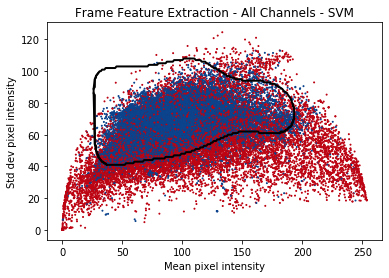

In [18]:
means = x_train[:,[0]]
stddevs = x_train[:,[1]]

color = ['#0b438c' if x==0 else '#bd0413' for x in y_train]
plt.scatter(means, stddevs, c=color, s=1)
plt.title("Frame Feature Extraction - All Channels - SVM")
plt.xlabel("Mean pixel intensity")
plt.ylabel("Std dev pixel intensity")

x_bottom = []
y_bottom = []
x_top = []
y_top = []
x_left = []
y_left = []
x_right = []
y_right = []
for i in range(0, 250):
    for j in range(20, 120):
        prediction = clf.predict(np.array([[i, j]]))
        if prediction == 0:
            x_bottom.append(i)
            y_bottom.append(j)
            break
    for j in range(120, 20, -1):
        prediction = clf.predict(np.array([[i, j]]))
        if prediction == 0:
            x_top.append(i)
            y_top.append(j)
            break
for j in range(40, 100):
    for i in range(10, 50):
        prediction = clf.predict(np.array([[i, j]]))
        if prediction == 0:
            x_left.append(i)
            y_left.append(j)
            break
for j in range(60, 80):
    for i in range(200, 150, -1):
        prediction = clf.predict(np.array([[i, j]]))
        if prediction == 0:
            x_right.append(i)
            y_right.append(j)
            break 
            
plt.plot(x_bottom, y_bottom, 'k', linewidth=2)
plt.plot(x_top, y_top, 'k', linewidth=2)
plt.plot(x_left, y_left,'k', linewidth=2)
plt.plot(x_right, y_right,'k', linewidth=2)

plt.show()

**Transform Data**

In [30]:
# use only first two features when graphing
x_train = x_train[:, :2]
x_test = x_test[:, :2]

for i in range(x_train.shape[0]):
    x_train[i, 1] *= 0.0001 * (x_train[i, 0] - 125) ** 2 + 2
    
for i in range(x_test.shape[0]):
    x_test[i, 1] *= 0.0001 * (x_test[i, 0] - 125) ** 2 + 2

y_train is shape  (64130, 1)
x_train is shape  (64130, 2)
y_test is shape  (81105, 1)
x_test is shape  (81105, 2)


In [51]:
print('y_train is shape ', y_train.shape)
print('x_train is shape ', x_train.shape)
print('y_test is shape ', y_test.shape)
print('x_test is shape ', x_test.shape)

y_train is shape  (64130, 1)
x_train is shape  (64130, 8)
y_test is shape  (81105, 1)
x_test is shape  (81105, 8)


In [56]:
# run GDA
phi, mu0, mu1, sigma0, sigma1 = compute_parameters(x_train[:10000], y_train[:10000])
accuracy, F1 = make_predictions(x_test, y_test, phi, mu0, mu1, sigma0, sigma1)
print('Accuracy = %f and F1 = %f' % (accuracy, F1))

Accuracy = 0.805635 and F1 = 0.572281


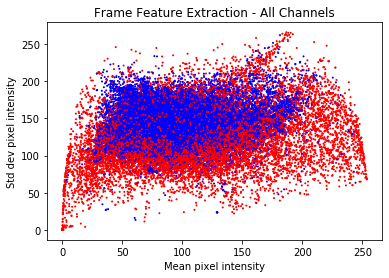

In [57]:
means = x_train[:,[0]]
stddevs = x_train[:,[1]]

color = ['blue' if x==0 else 'red' for x in y_train]
plt.scatter(means, stddevs, c=color, s=1)
plt.title("Frame Feature Extraction - All Channels")
plt.xlabel("Mean pixel intensity")
plt.ylabel("Std dev pixel intensity")
plt.show()

In [32]:
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
predictions = clf.predict(x_test)
predictions = np.array(predictions).reshape(len(predictions), 1)
accuracy = np.sum((predictions == y_test) * 1) / len(predictions)
print(accuracy)

0.8083718636335614


In [34]:
tp = tn = fp = fn = 0
for i in range(len(y_test)):
    if predictions[i] == True and y_test[i] == 1:
        tp += 1
    if predictions[i] == True and y_test[i] == 0:
        fp += 1
    if predictions[i] == False and y_test[i] == 1:
        fn += 1
    if predictions[i] == False and y_test[i] == 0:
        tn += 1
F1 = 2 * tp / (2 * tp + fn + fp)
print(F1)

0.5626160860021387


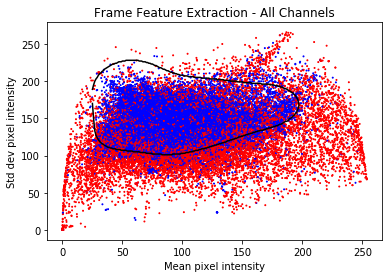

In [35]:
color = ['blue' if x==0 else 'red' for x in y_train]
plt.scatter(means, stddevs, c=color, s=1)
plt.title("Frame Feature Extraction - All Channels")
plt.xlabel("Mean pixel intensity")
plt.ylabel("Std dev pixel intensity")

x_bottom = []
y_bottom = []
x_top = []
y_top = []
for i in range(0, 250):
    for j in range(20, 250):
        prediction = clf.predict(np.array([[i, j]]))
        if prediction == 0:
            x_bottom.append(i)
            y_bottom.append(j)
            break
    for j in range(250, 20, -1):
        prediction = clf.predict(np.array([[i, j]]))
        if prediction == 0:
            x_top.append(i)
            y_top.append(j)
            break
        
plt.plot(x_bottom, y_bottom, 'k')
plt.plot(x_top, y_top, 'k')

plt.show()